In [1]:
import os.path as op
import glob
import numpy as np
import mne
import library as lib
import hcp
from hcp.preprocessing import apply_ica_hcp, interpolate_missing_channels


In [11]:
# raw = lib.hcp_utils.hcp_preprocess_ssp_ica(subject='100307', run_index=0, recordings_path='/Volumes/MEG-HUB/HCP-MEG/',
#                                            hcp_path='/Volumes/MEG-HUB/HCP/')
subject = '100307'
run_index = 0
recordings_path = '/Volumes/MEG-HUB/HCP-MEG/'
hcp_path = '/Volumes/MEG-HUB/HCP/'
n_jobs = 1
n_ssp = 16
decim = 8
fmin, fmax = None, 200
annots = hcp.io.read_annot_hcp(
    subject, hcp_path=hcp_path, data_type='rest',
    run_index=run_index)
ica_mat = hcp.io.read_ica_hcp(
    subject, hcp_path=hcp_path, data_type='rest',
    run_index=run_index)
raw = hcp.io.read_raw_hcp(
    subject, hcp_path=hcp_path, data_type='rest',
    run_index=run_index)
raw_noise = hcp.io.read_raw_hcp(
    subject, hcp_path=hcp_path, data_type='noise_empty_room',
    run_index=0)

Reading 4D PDF file /Volumes/MEG-HUB/HCP/100307/unprocessed/MEG/3-Restin/4D/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... no headshape file supplied, doing nothing.
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Reading 0 ... 774850  =      0.000 ...   380.853 secs...
Reading 4D PDF file /Volumes/MEG-HUB/HCP/100307/unprocessed/MEG/1-Rnoise/4D/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... no headshape file supplied, doing nothing.
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Reading 0 ... 610353  =      0.000 ...   300.000 secs...


In [12]:
exclude = np.array(annots['ica']['ecg_eog_ic']) - 1
for this_raw in (raw_noise, raw):
    lib.raw.decimate_raw(this_raw, decim=decim)
    this_raw.info['bads'] = annots['channels']['all']
    this_raw.pick_types(meg='mag', ref_meg=False)
    this_raw.filter(fmin, fmax, n_jobs=n_jobs, method='iir',
                    iir_params=dict(order=4, ftype='butter'))
    if len(exclude) > 0:
        print('applying ICA')
        apply_ica_hcp(this_raw, ica_mat=ica_mat, exclude=exclude)

projs_noise = mne.compute_proj_raw(raw_noise, n_mag=n_ssp)
raw.add_proj(projs_noise)
raw.apply_proj()
raw = interpolate_missing_channels(raw, subject=subject, data_type='rest',
                                   hcp_path=hcp_path)

applying ICA
applying ICA
300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
No gradiometers found. Forcing n_grad to 0
Adding projection: axial-Raw-0.000-300.003-PCA-01
Adding projection: axial-Raw-0.000-300.003-PCA-02
Adding projection: axial-Raw-0.000-300.003-PCA-03
Adding projection: axial-Raw-0.000-300.003-PCA-04
Adding projection: axial-Raw-0.000-300.003-PCA-05
Adding projection: axial-Raw-0.000-300.003-PCA-06
Adding projection: axial-Raw-0.000-300.003-PCA-07
Adding projection: axial-Raw-0.000-300.003-PCA-08
Adding projection: axial-Raw-0.000-300.003-PCA-09
Adding projection: axial-Raw-0.000-300.003-PCA-10
Adding projection: axial-Raw-0.000-300.003-PCA-11
Adding projection: axial-Raw-0.000-300.003-PCA-12
Adding projection: axial-Raw-0.000-300.003-PCA-13
Adding projection: axial-Raw-0.000-300.003-PCA-14
Adding projection: axial-Raw-0.000-300.003-PCA-15
Adding projection: axial-Raw-0.000-300.003-PCA-16
16 projection items deactivated
Cr

Using matplotlib backend: MacOSX


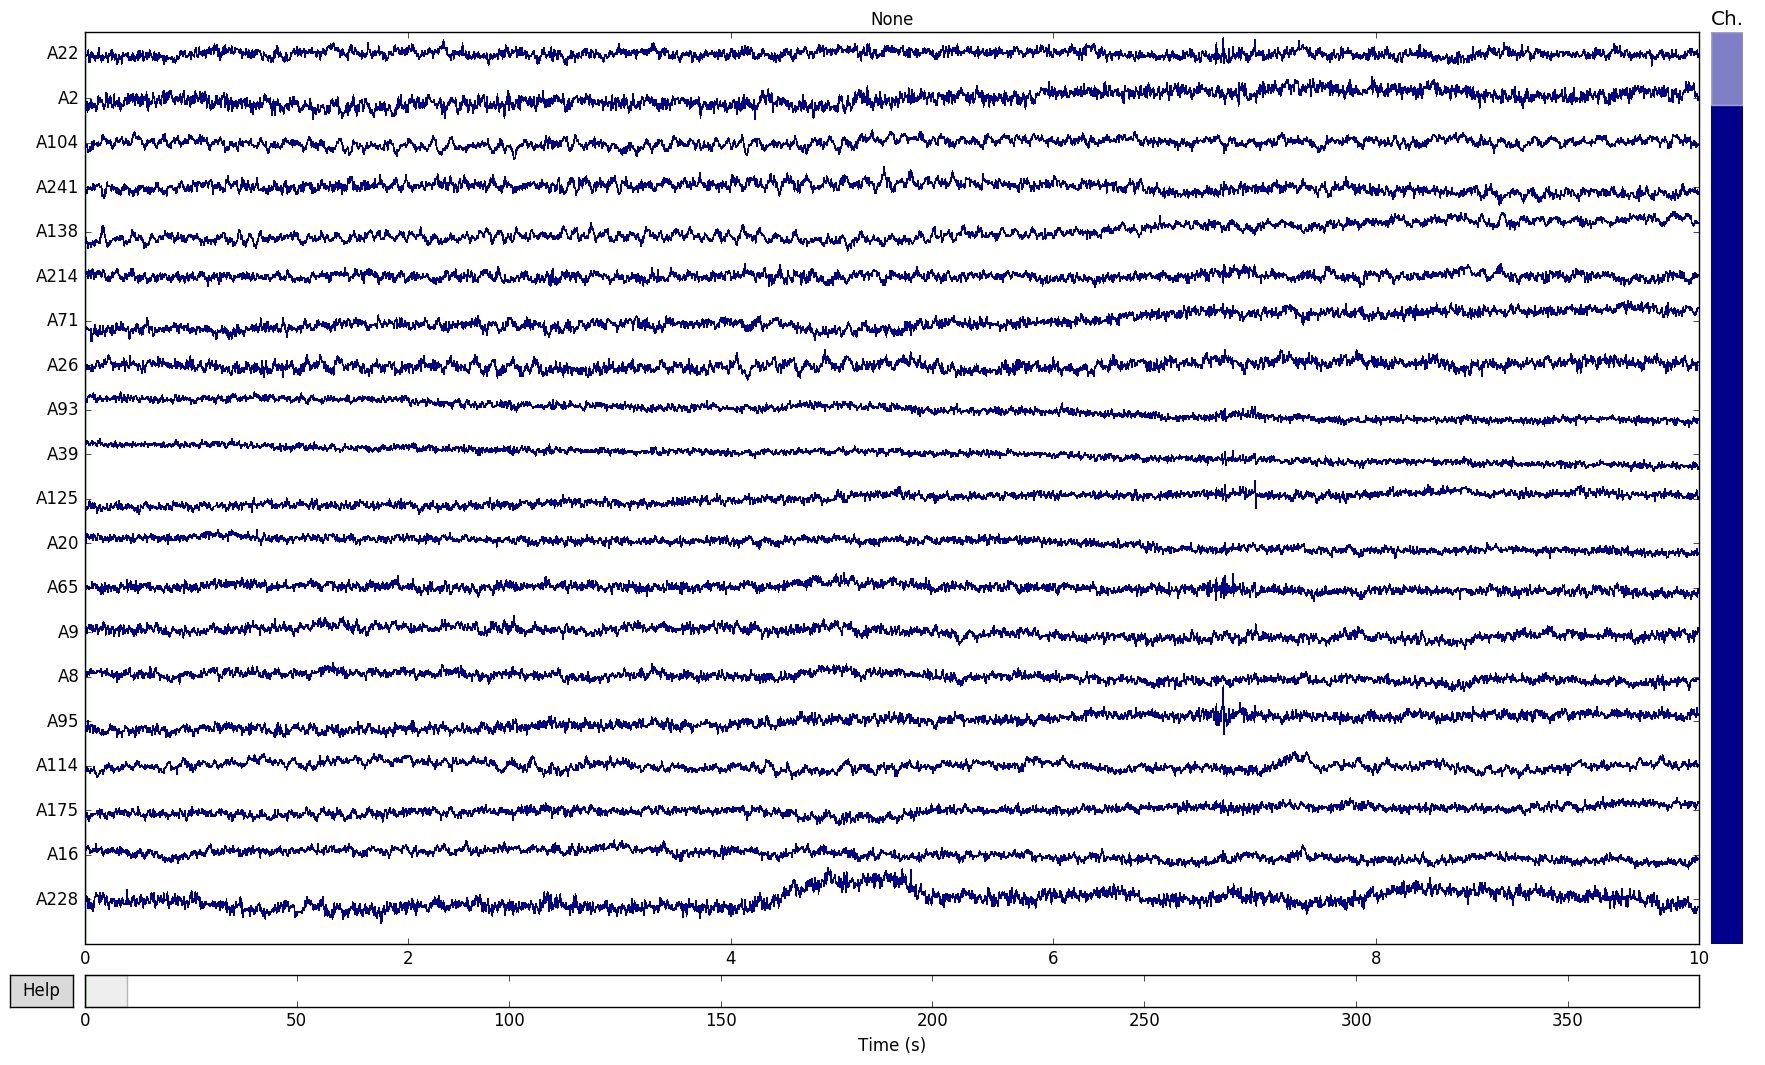

In [13]:
%matplotlib
raw.plot()

In [45]:
raw.index_as_time(raw.last_samp)

/Users/dengemann/github/mne-python/mne/utils.py:558: DeprecationWarning: Function index_as_time is deprecated; index_as_time is deprecated and will be removed in 0.13, use raw.times[idx] (or raw.times[idx + raw.first_samp] instead
  warnings.warn(msg, category=DeprecationWarning)


array([ 380.85237333])

array([[    2,     0,  3000],
       [ 7122,     0,  3000],
       [14243,     0,  3000],
       [21364,     0,  3000],
       [28485,     0,  3000],
       [35605,     0,  3000],
       [42726,     0,  3000],
       [49847,     0,  3000],
       [56968,     0,  3000],
       [64089,     0,  3000],
       [71209,     0,  3000],
       [78330,     0,  3000],
       [85451,     0,  3000]])

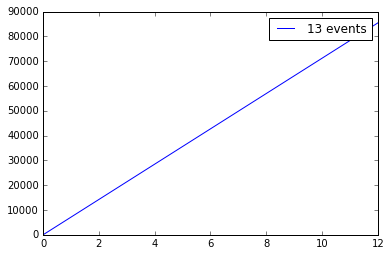

In [52]:
event_id = 3000
start = 0.
duration = 28
events = mne.make_fixed_length_events(
    raw, id=event_id, start=start, duration=duration)
events + np.array((1,))
plt.plot(events[:, 0], label='%d events' % len(events))
plt.legend()
events + np.array((, 0, 0))

# checkout overlapping events

Make sure things look approximately linear

/Users/dengemann/github/mne-python/mne/utils.py:558: DeprecationWarning: Function index_as_time is deprecated; index_as_time is deprecated and will be removed in 0.13, use raw.times[idx] (or raw.times[idx + raw.first_samp] instead
  warnings.warn(msg, category=DeprecationWarning)


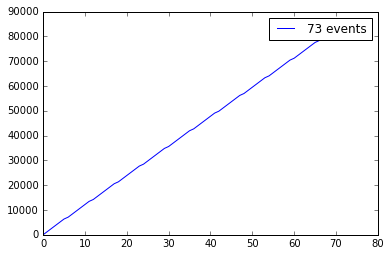

In [134]:
%matplotlib inline 
events = lib.event.make_overlapping_events(
            raw, 3000, stop=raw.index_as_time(raw.last_samp), overlap=5, duration=28.0)

import matplotlib.pyplot as plt
plt.plot(events[:, 0], label='%d events' % len(events))
plt.legend()

In [79]:
duration = 28
decim = 1

picks = mne.pick_types(raw.info, meg=True, ref_meg=False)
epochs = mne.Epochs(
    raw, picks=picks, events=events, event_id=3000, tmin=0, tmax=duration,
    detrend=1, baseline=None,
    reject=dict(mag=5e-12), preload=False, decim=decim, proj=True)
print(len([e for e in epochs]))

73 matching events found
No baseline correction applied
0 projection items activated
    Rejecting  epoch based on MAG : ['A22', 'A2', 'A104', 'A241', 'A138', 'A214', 'A71', 'A26', 'A93', 'A39', 'A20', 'A65', 'A8', 'A95', 'A114', 'A16', 'A228', 'A191', 'A37', 'A170', 'A207', 'A112', 'A224', 'A82', 'A238', 'A220', 'A28', 'A239', 'A165', 'A204', 'A25', 'A72', 'A11', 'A160', 'A63', 'A155', 'A10', 'A127', 'A67', 'A115', 'A247', 'A194', 'A242', 'A78', 'A168', 'A223', 'A219', 'A186', 'A76', 'A188', 'A231', 'A45', 'A180', 'A99', 'A215', 'A235', 'A181', 'A38', 'A230', 'A24', 'A66', 'A42', 'A96', 'A57', 'A86', 'A56', 'A116', 'A151', 'A120', 'A189', 'A80', 'A210', 'A113', 'A137', 'A135', 'A167', 'A75', 'A240', 'A206', 'A107', 'A43', 'A200', 'A102', 'A183', 'A199', 'A122', 'A62', 'A21', 'A229', 'A84', 'A213', 'A55', 'A32', 'A85', 'A146', 'A58', 'A60', 'A88', 'A79', 'A169', 'A54', 'A203', 'A145', 'A103', 'A163', 'A139', 'A49', 'A166', 'A156', 'A128', 'A68', 'A159', 'A236', 'A161', 'A121', 'A4', 'A

Effective window size : 60.005 (s)


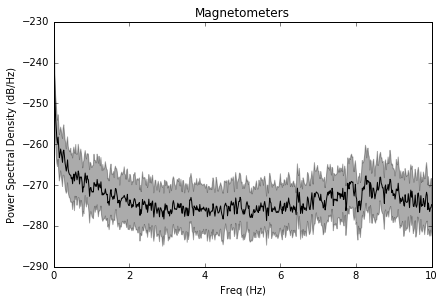

In [94]:
raw.plot_psd(n_fft=1024*16, fmax=10, n_overlap=2048);

In [91]:
raw.plot_psd?

In [128]:
psds, freqs = mne.time_frequency.psd_multitaper(epochs, bandwidth=0.5, fmax=150)

Loading data for 60 events and 7122 original time points ...
CPU times: user 11min 52s, sys: 12.3 s, total: 12min 4s
Wall time: 11min 48s


In [129]:
psds.shape

(60, 248, 3561)

In [131]:
freqs

NameError: name 'freqs' is not defined

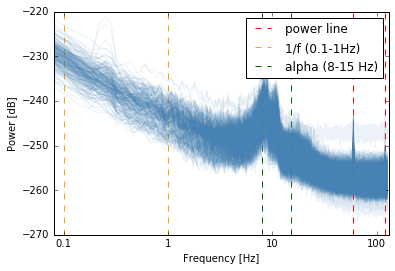

In [127]:
plt.figure(dpi=600)
plt.axvline(np.log10(60), color='red', linestyle='--', label='power line')
plt.axvline(np.log10(120), color='red', linestyle='--')
plt.axvline(np.log10(0.1), color='orange', linestyle='--', label='1/f (0.1-1Hz)')
plt.axvline(np.log10(1), color='orange', linestyle='--')
plt.axvline(np.log10(8), color='darkgreen', linestyle='--', label='alpha (8-15 Hz)')
plt.axvline(np.log10(15), color='darkgreen', linestyle='--')

plt.plot(np.log10(times), 10 * np.log10(psds.mean(0)).T, color='steelblue', alpha=0.1);
plt.xlim(np.log10(0.08), np.log10(130))
plt.legend()
plt.xticks(np.log10([0.1, 1, 10, 100]), [0.1, 1, 10, 100])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power [dB]')
plt.savefig('/Users/dengemann/Dropbox/check_alpha_overview.png', dpi=600)

In [112]:
raw.info['highpass']